In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import float32, zeros, ones, eye, as_tensor, tensor

from sbi.analysis import pairplot, marginal_plot

from gbi.GBI import GBInference
from gbi.hh.train_gbi import MaeDistZ
import gbi.hh.utils as utils
from gbi.hh.HodgkinHuxley import HodgkinHuxley
from gbi.hh.HodgkinHuxleyStatsMoments import HodgkinHuxleyStatsMoments

/home/anonymizeduser/anaconda3/envs/gbi/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
plt.style.use('../../../.matplotlibrc')

### Load saved data with 100k simulations

In [4]:
path = "/home/anonymizeduser/Documents/neuralgbi/results/hh_allen"

In [5]:
with open(f"{path}/gbi_pred_m/0/01_prior_theta.pkl", "rb") as handle:
    prior_theta = pickle.load(handle)
with open(f"{path}/gbi_pred_m/0/01_prior_pred.pkl", "rb") as handle:
    prior_x = pickle.load(handle)

with open(f"{path}/gbi_inference/inference_gbi.pkl", "rb") as handle:
    inference_gbi = pickle.load(handle)

with open(f"{path}/gbi_pred_m/0/02_posterior_samples_gbi_allen.pkl", "rb") as handle:
    gbi_posterior_theta = pickle.load(handle)
with open(f"{path}/gbi_pred_m/0/03_posterior_predictive_stats_gbi.pkl", "rb") as handle:
    gbi_posterior_x = pickle.load(handle)
with open(f"{path}/gbi_pred_m/0/03_posterior_predictive_traces_gbi.pkl", "rb") as handle:
    gbi_posterior_traces = pickle.load(handle)

with open(f"{path}/npe_pred_m/3_allen_1000000/04_npe_theta.pkl", "rb") as handle:
    npe_posterior_theta = pickle.load(handle)
with open(f"{path}/npe_pred_m/3_allen_1000000/04_npe_stats.pkl", "rb") as handle:
    npe_posterior_x = pickle.load(handle)
with open(f"{path}/npe_pred_m/3_allen_1000000/04_npe_traces.pkl", "rb") as handle:
    npe_posterior_traces = pickle.load(handle)

### Generate simulator, prior, x_o

In [6]:
seed = 1
n_xcorr = 0
n_mom = 4
n_summary = 7

In [7]:
true_params, labels_params = utils.obs_params(reduced_model=False)

list_cells_AllenDB = [518290966, 57, 0.0234 / 126]

ephys_cell = list_cells_AllenDB[0]
sweep_number = list_cells_AllenDB[1]
A_soma = list_cells_AllenDB[2]
junction_potential = -14

obs = utils.allen_obs_data(
    ephys_cell=ephys_cell, sweep_number=sweep_number, A_soma=A_soma
)
obs["data"] = obs["data"] + junction_potential
I = obs["I"]
dt = obs["dt"]
t_on = obs["t_on"]
t_off = obs["t_off"]

sim = HodgkinHuxley(
    I, dt, V0=obs["data"][0], reduced_model=False, cython=True, prior_log=False
)
stats = HodgkinHuxleyStatsMoments(
    t_on=t_on, t_off=t_off, n_xcorr=n_xcorr, n_mom=n_mom, n_summary=n_summary
)

In [8]:
obs_stats_ls, all_obs = utils.load_all_allen()
x_target_vals = torch.as_tensor(np.asarray(obs_stats_ls), dtype=torch.float32)

In [9]:
prior = utils.prior(
    true_params=true_params,
    prior_uniform=True,
    prior_extent=True,
    prior_log=False,
    seed=0,
)
limits = torch.stack(
    [
        prior.support.base_constraint.lower_bound,
        prior.support.base_constraint.upper_bound,
    ]
).T
time_vec_obs = np.linspace(np.min(sim.t), np.max(sim.t), len(all_obs[0]["data"]))

### Colors

In [10]:
col_xo = "k"
col_npe = "C2"
col_gbi = "C1"
col_gbi1 = "#a6bddb"
col_gbi2 = "#3690c0"
col_gbi3 = "#045a8d"

### Panel A

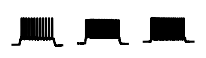

In [11]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 3, figsize=(2.4, 0.5))
        
    for i in range(3):
        xo  = all_obs[i]
        _ = ax[i].plot(time_vec_obs, xo["data"], c=col_xo)

        _ = ax[i].set_xlabel("")
        _ = ax[i].set_ylabel("")
        _ = ax[i].set_ylim([-100, 60])
        _ = ax[i].spines["left"].set_visible(False)
        _ = ax[i].spines["bottom"].set_visible(False)
        _ = ax[i].set_xticks([])
        _ = ax[i].set_yticks([])
    plt.savefig("../svg/panel_a_appendix5.svg")
    plt.show()

### Panel B

In [12]:
cols = [
    "#a6cee3",
    "#1f78b4",
    "#b2df8a",
    "#33a02c",
    "#fb9a99",
    "#e31a1c",
    "#fdbf6f",
    "#ff7f00",
    "#cab2d6",
    "#6a3d9a",
]

### Panel C

In [13]:
labels_plot = [r"$g_{Na}$", r"$g_K$", r"$g_{\mathrm{leak}}$", r"$g_M$", r"$t_{max}$", r"$-V_T$", r"$noise$", r"$-E_{\mathrm{leak}}$"]

In [14]:
from scipy.ndimage import gaussian_filter

In [15]:
def gen_subplot_data(data, limits, counter):
    y_vals, x_vals = np.histogram(data[0][:, counter].numpy(), bins=30, range=limits[counter].numpy())
    y_vals = gaussian_filter(y_vals, 3.0)  # gaussian_kde(y_vals, bw_method="scott")(np.linspace(limits[counter, 0], limits[counter, 1], 30))
    return x_vals[:-1], y_vals

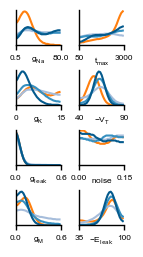

In [16]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(4, 2, figsize=(1.4, 2.8))
    counter = 0
    for a in range(2):
        for b in range(4):
            ax[b, a].plot(*gen_subplot_data(npe_posterior_theta, limits, counter), c=col_npe)
            ax[b, a].plot(*gen_subplot_data(gbi_posterior_theta["beta_25"], limits, counter), c=col_gbi1)
            ax[b, a].plot(*gen_subplot_data(gbi_posterior_theta["beta_50"], limits, counter), c=col_gbi2)
            ax[b, a].plot(*gen_subplot_data(gbi_posterior_theta["beta_100"], limits, counter), c=col_gbi3)
            ax[b, a].set_xlim(limits[counter])
            ax[b, a].set_xticks(limits[counter])
            ax[b, a].set_xlabel(labels_plot[counter], labelpad=-4)
            ax[b, a].set_yticks([])
            ax[b, a].set_ylim(bottom=0)
            counter += 1
    plt.subplots_adjust(hspace=0.7, wspace=0.4)
    plt.savefig("../svg/panel_c_appendix5.svg")

### Panel D

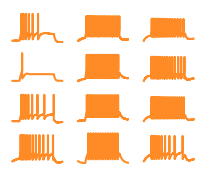

In [18]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(4, 3, figsize=(2.4, 2.0))
        
    for sample_id in range(4):
        for i in range(3):
            predictive = npe_posterior_traces[i][sample_id]
            _ = ax[sample_id, i].plot(sim.t, predictive["data"], c=col_npe, alpha=0.9)

            _ = ax[sample_id, i].set_xlabel("")
            _ = ax[sample_id, i].set_ylabel("")
            _ = ax[sample_id, i].set_ylim([-100, 60])
            _ = ax[sample_id, i].spines["left"].set_visible(False)
            _ = ax[sample_id, i].spines["bottom"].set_visible(False)
            _ = ax[sample_id, i].set_xticks([])
            _ = ax[sample_id, i].set_yticks([])
    plt.savefig("../svg/panel_d2_appendix5.svg")
    plt.show()

### Panel E

In [19]:
all_gbi_distances = []
for key in gbi_posterior_x.keys():
    pred_stats = gbi_posterior_x[key]
    gbi_av_dists = []
    for predictives, xo in zip(pred_stats, obs_stats_ls):
        dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
        gbi_av_dists.append(torch.mean(dists))
    all_gbi_distances.append(gbi_av_dists)

In [20]:
npe_av_dists = []
for predictives, xo in zip(npe_posterior_x, obs_stats_ls):
    dists = inference_gbi.distance_func(predictives.unsqueeze(1), xo)
    npe_av_dists.append(torch.mean(dists))

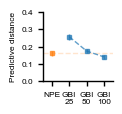

In [21]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(0.9, 0.9))
    _ = ax.errorbar([1, 2, 3], [np.mean(dist) for dist in all_gbi_distances], yerr=[np.std(dist) for dist in all_gbi_distances], fmt='--s', color=col_gbi, label="GBI", lw=1, alpha=0.7)

    ax.errorbar([0], np.mean(npe_av_dists), yerr=np.std(npe_av_dists), fmt='--s', color=col_npe, label="NPE", lw=1, alpha=0.7)
    ax.axhline(np.mean(npe_av_dists), color=col_npe, ls='--', alpha=0.2, lw=1)

    ax.set_xticks([0, 1, 2, 3])
    ax.set_xlim([-0.5, 3.5])
    ax.set_xticklabels(["NPE", "GBI\n25", "GBI\n50", "GBI\n100"])
    ax.set_ylabel("Predictive distance")
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
    ax.set_ylim([0, 0.4])
    plt.savefig(f"../svg/panel_e_appendix5.svg")

### Assemble figure

In [22]:
import time
import IPython.display as IPd
from svgutils.compose import *

In [25]:
def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '10pt', 'font': 'Arial', 'weight': '800'}
kwargs_textstd = {'size': '6pt', 'font': 'Arial'}

f = Figure("12.7cm", "6.1cm",
    
    Panel(
          SVG(f"../svg/panel_a.svg").scale(svg_scale),
          Text("a", -5, 13.0, **kwargs_text),
          Text("Observations", 68, 13.0, **kwargs_textstd),
    ).move(10, 0),
    
    Panel(
          SVG(f"../svg/panel_c.svg").scale(svg_scale),
          Text("c", -5, 13.0, **kwargs_text),
    ).move(220, 0),
           
    Panel(
          SVG(f"../svg/panel_d2.svg").scale(svg_scale),
          Text("b", -5, 4.0, **kwargs_text),
          Text("NPE (1M sims) predictives", 46, 4.0, **kwargs_textstd),
    ).move(10, 60),
    
    Panel(
          SVG(f"../svg/panel_e.svg").scale(svg_scale),
          Text("d", -6, 15.0, **kwargs_text),
    ).move(375, -2),
)

!mkdir -p fig
f.save("../fig/fig6_appendix6.svg")
svg("../fig/fig6_appendix6.svg")